# Seasonal Anomaly Detection in Streaming Data

###**Problem Statement:**

Your task is to develop a Python script capable of detecting anomalies in a continuous data stream. This stream, simulating real-time sequences of floating-point numbers, could represent various metrics such as financial transactions or system metrics. Your focus will be on identifying unusual patterns, such as exceptionally high values or deviations from the norm.

###**Anomaly Detection in Streaming Data**

Anomaly detection in streaming data involves identifying unusual patterns or instances that deviate significantly from the expected behavior in a continuous flow of data. Unlike static datasets where the entire data is available for analysis, streaming data refers to a continuous, unending flow of data that is observed in real-time or near real-time. Anomalies, also known as outliers or novelties, can represent events, observations, or data points that differ significantly from the norm or expected behavior within this continuous data flow.

1. **Challenges in Anomaly Detection in Stream Data:**


    i. Real-time Processing: The need to process data as it arrives in real-time or near real-time.
    ii. Concept Drift: Changes in underlying data patterns or characteristics over time, requiring continuous adaptation of anomaly detection models.
    iii. Scalability: Handling large volumes of data efficiently and effectively.
    iv. Noise Handling: Filtering out noise or irrelevant data fluctuations that might be mistaken for anomalies.
    v. Imbalanced Data: Often, anomalies are rare events compared to regular data points, leading to imbalanced datasets.
    
2. **Methods and Techniques:**


    i.Statistical Methods: Techniques like moving averages, Z-score, or quantile-based methods to detect deviations from statistical norms.
    ii. Machine Learning Approaches: Supervised, unsupervised, or semi-supervised techniques employing algorithms such as clustering, classification, or density estimation.
    iii. Ensemble Methods: Combinations of multiple anomaly detection models or algorithms to improve accuracy and robustness.
    iv. Incremental Learning: Algorithms designed to learn and adapt to changes in the data stream gradually.

3. **Strategies for Anomaly Detection in Stream Data:**

- Window-based Techniques: Employing sliding windows to analyze a subset of recent data for anomaly detection.
- Model Updating: Continuous or periodic model retraining or adaptation to accommodate changes in the data distribution (concept drift).
- Feature Engineering: Identification and extraction of relevant features that represent anomalous behavior in streaming data.
- Threshold-based Methods: Setting dynamic thresholds based on observed data patterns to identify anomalies.

4. **Applications:**


    i. Cybersecurity: Identifying network intrusions or unusual activities.    
    ii. Financial Services: Detecting fraudulent transactions or unusual trading behavior.
    iii. Healthcare: Monitoring patient vital signs for abnormal patterns indicating health issues.
    iv. IoT and Sensor Data: Identifying malfunctioning devices or anomalies in sensor readings.

### 1. AWS CloudWatch System Metrics

- **Category**: Unsupervised Anomaly Detection on Time Series data
- **Algorithm**: Streaming Moving Average

**Description**:
   
    i. Purpose: To compute a moving average of incoming data points in a streaming fashion.
   
    ii. Operation: Moving Average is commonly used in Time Series problems.
    This is done by taking the sum of recent data points and divide them by the time period.
    Furthermore, we simple check if the new record is far from the expected value.
    The expected value range is computed using the formula Moving Average + standard deviation * threshold;
    if it is out of the expected value range, it is reported as an anomaly.
   
    iii. Advantages: Simple to implement and computationally efficient for obtaining smoothed trends in streaming data.

    iv. Limitations: May not capture sudden changes or anomalies effectively, as it focuses on overall trends.

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle #create kaggle directory
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d boltzmannbrain/nab

  0% 0.00/1.64M [00:00<?, ?B/s]
100% 1.64M/1.64M [00:00<00:00, 121MB/s]


In [ ]:
zip_path='/content/nab.zip'

In [ ]:
import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for member in zip_ref.namelist():
      zip_ref.extract(member)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

<Axes: >

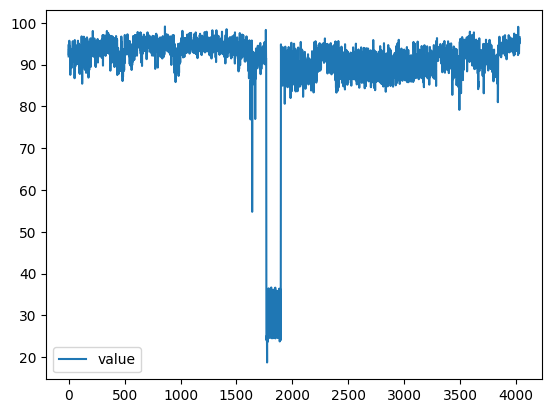

In [ ]:
cpu = pd.read_csv('/content/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_825cc2.csv')
cpu.plot()

<Axes: >

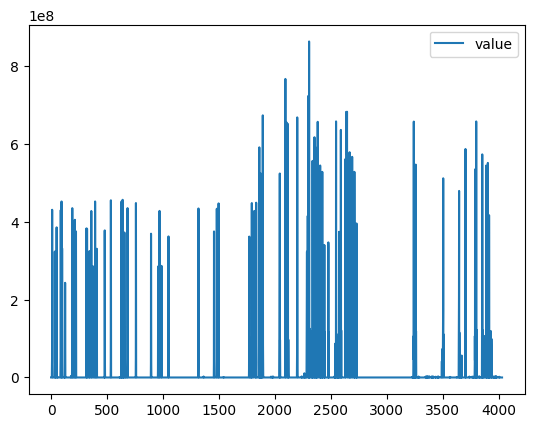

In [ ]:
diskwrite = pd.read_csv('/content/realAWSCloudwatch/realAWSCloudwatch/ec2_disk_write_bytes_c0d644.csv')
diskwrite.plot()

<Axes: >

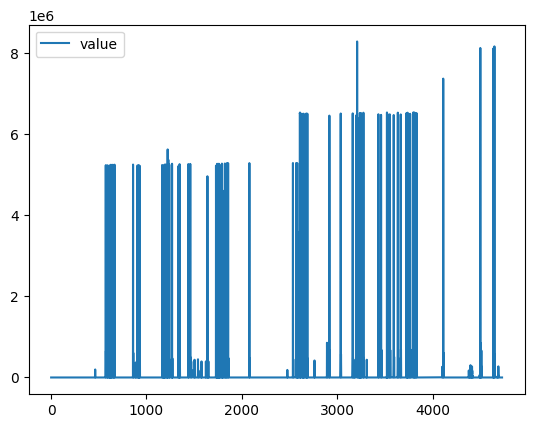

In [ ]:
network = pd.read_csv('/content/realAWSCloudwatch/realAWSCloudwatch/ec2_network_in_5abac7.csv')
network.plot()

In [ ]:
def plot_anomalies(dfs, algorithm, parameters, title=False, dumping=False):
    '''Plot the Streaming Data (an Anomalies)'''
    n = len(dfs)
    lin, col = 1, 1
    for i in range(1, n+1):
        if lin * col < i:
            if lin == col: col += 1
            else: lin += 1
    # create a subplot
    model_name = algorithm.__name__
    fig, axes = plt.subplots(lin, col, squeeze=False, sharex=False, sharey=False, figsize=(col*12, lin*3))
    fig.suptitle(f'Anomaly Detection - {model_name}')
    xlin, xcol = 0, 0
    for i, df in enumerate(dfs):
        # get data
        get_timestamp = lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').timestamp()
        X = df.timestamp.apply(lambda x: int(get_timestamp(x)))
        Y = df.value
        # predict anomalies
        model = algorithm(**parameters)
        preds = [model.detect(i, v, dumping=True) for i, v in zip(X, Y)]
        pred, values, stds = tuple(zip(*preds))
        # plot the results
        af  = pd.DataFrame(data={'x':X, 'value':Y, 'pred':pred})
        af2 = pd.DataFrame(data={'x':X, 'value':values, 'pred':pred, 'std': stds})
        af2['ymin'] = af2['value'] - af2['std']
        af2['ymax'] = af2['value'] + af2['std']
        size = af.pred.astype(int) * 20
        sns.lineplot(ax=axes[xlin, xcol], data=af, x='x', y='value')
        sns.scatterplot(ax=axes[xlin, xcol], data=af, x='x', y='value', hue='pred', s=size)
        if dumping: axes[xlin, xcol].fill_between(af2.x, af2.value, af2.ymax, facecolor='green', alpha=0.2)
        if title: axes[xlin, xcol].set_title(f'{title[i]}')
        # update posix
        xlin += 1
        if xlin == lin: xlin,xcol = 0, xcol+1
    plt.tight_layout()
    plt.show()

In [ ]:
class StreamingMovingAverage:
    '''Moving Average algorithm'''
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html

    def __init__(self, threshold=1.5) -> None:
        # Parameters
        self.max_deviation_from_expected = threshold
        self.min_nof_records_in_model = 3
        self.max_nof_records_in_model = 3 * self.min_nof_records_in_model

    def detect(self, timestamp: int, value: float, dumping: bool=False) -> bool:
        '''Detect if is a Anomaly'''
        self._update_state(timestamp, value)
        expected_value = self._expected_value(timestamp)
        # is there enough data and is not NaN value
        response, curr_value, deviation = False, value, 0.0
        if self._enough_data() and not np.isnan(expected_value):
            # is the value out of the boundary? when it decrease
            curr_value = expected_value
            deviation = self._standard_deviation() * self.max_deviation_from_expected
            # when it is higher than expected
            if expected_value + deviation < value:
                response = True
        # dumping or not
        if dumping: return (response, curr_value, deviation)
        else: return response

    def _update_state(self, timestamp: int, value: float) -> None:
        '''Update the model state'''
        # check if it is the first time the model is run or if there is a big interval between the timestamps
        if not hasattr(self, 'previous_timestamp'):
            self._init_state(timestamp)
        # update the model state
        self.previous_timestamp = timestamp
        self.data_streaming.append(value)
        # is there a lot of data? remove one record
        if len(self.data_streaming) > self.max_nof_records_in_model:
            self.data_streaming.pop(0)

    def _init_state(self, timestamp: int) -> None:
        '''Reset the parameters'''
        self.previous_timestamp = timestamp
        self.data_streaming = list()

    def _enough_data(self) -> bool:
        '''Check if there is enough data'''
        return len(self.data_streaming) >= self.min_nof_records_in_model

    def _expected_value(self, timestamp: int) -> float:
        '''Return the expected value'''
        data = self.data_streaming
        data = pd.Series(data=data, dtype=float)
        many = self.min_nof_records_in_model
        return data.rolling(many, min_periods=1).mean().iloc[-1]

    def _standard_deviation(self) -> float:
        '''Return the standard deviation'''
        data = self.data_streaming
        return np.std(data, axis=0)

    def get_state(self) -> dict:
        '''Get the state'''
        self_dict = {key: value for key, value in self.__dict__.items()}
        return pickle.dumps(self_dict, 4)

    def set_state(self, state) -> None:
        '''Set the state'''
        _self = self
        ad = pickle.loads(state)
        for key, value in ad.items():
            setattr(_self, key, value)

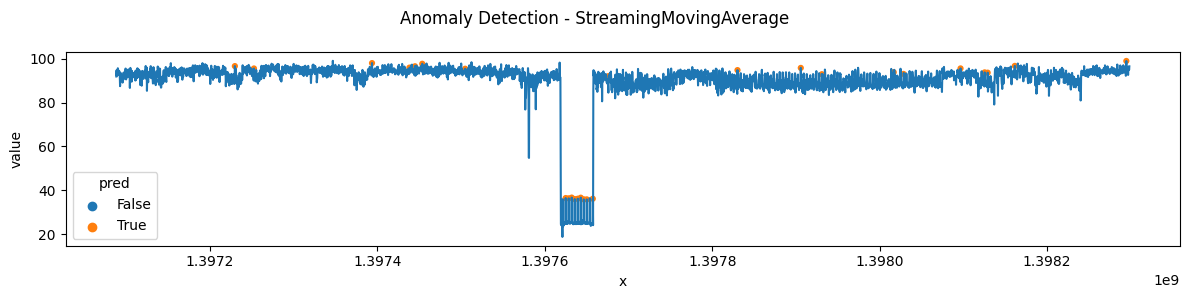

In [ ]:
algorithm = StreamingMovingAverage
parameters = {'threshold': 2}
plot_anomalies([cpu], algorithm, parameters)

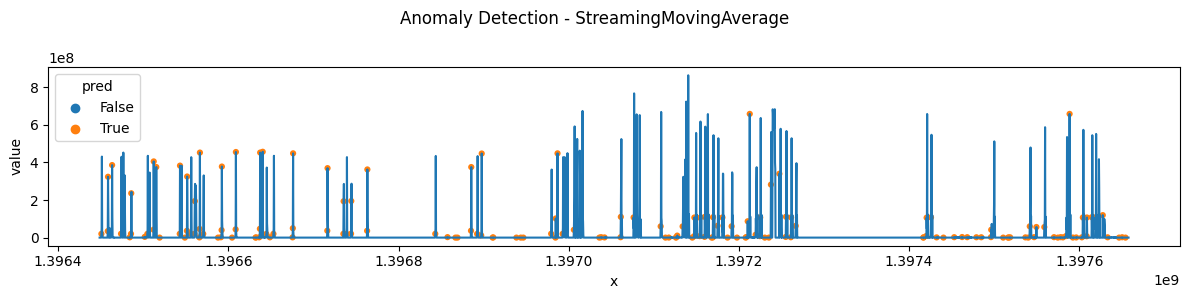

In [ ]:
algorithm = StreamingMovingAverage
parameters = {'threshold': 2}
plot_anomalies([diskwrite], algorithm, parameters)

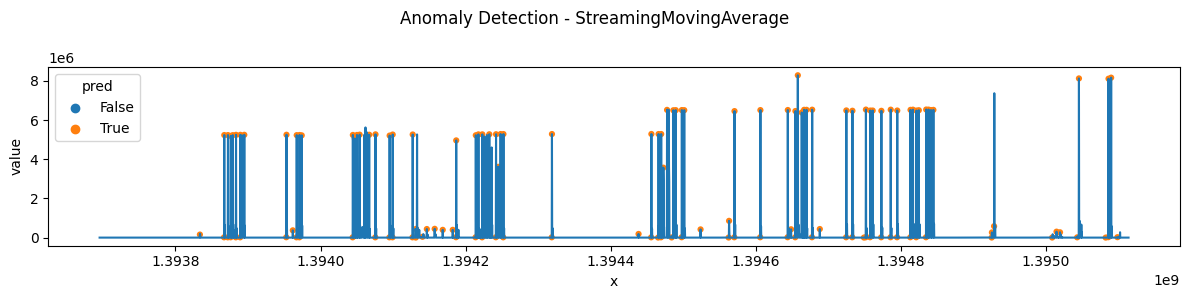

In [ ]:
algorithm = StreamingMovingAverage
parameters = {'threshold': 2.1}
plot_anomalies([network], algorithm, parameters)

<Axes: >

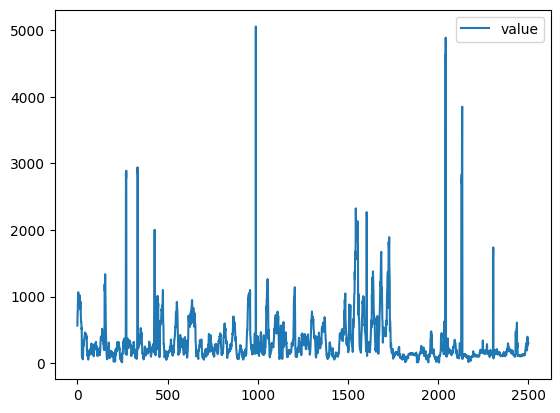

In [ ]:
traffic = pd.read_csv('/content/realTraffic/realTraffic/TravelTime_387.csv')
traffic.plot()

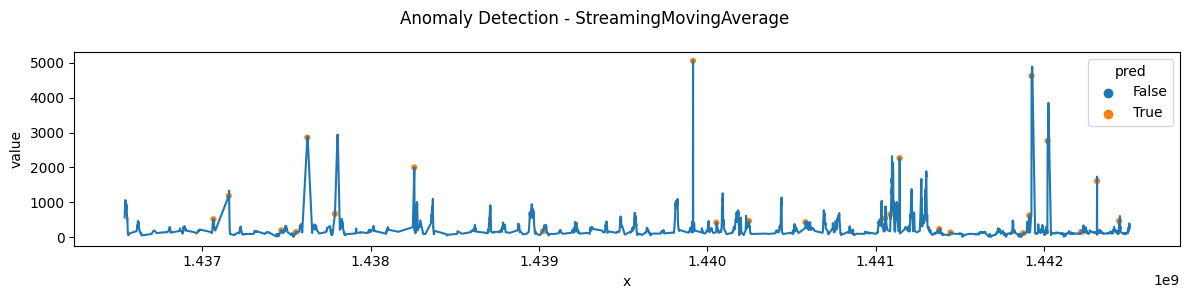

In [ ]:
algorithm = StreamingMovingAverage
parameters = {'threshold': 2}
plot_anomalies([traffic], algorithm, parameters)

### 2. HTML Stream Anomaly Detection

- **Category**: Unsupervised Anomaly Detection on Time Series data
- **Algorithm**: Streaming Half-Space-Trees (HS-Trees)


**Description**:

    i. Type: Anomaly detection algorithm for evolving data streams.

    ii. Purpose: Detect anomalies in evolving data streams where anomalies are rare.

    iii. Operation: Utilizes an ensemble of random HS-Trees constructed without any data. Each tree in the ensemble represents a decision boundary (half-space) splitting the data.

    iv. Advantages: Works well with rare anomalies, doesn't require model restructuring, and has constant time complexity and memory requirements.

    v. Limitations: May require parameter tuning; performance might be influenced by parameter settings.

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

class Node:
  def __init__(self, left=None, right=None, r=0, l=0, split_attrib=0, split_value=0.0, depth=0):
      self.left = left
      self.right = right
      self.r = r
      self.l = l
      self.split_attrib = split_attrib
      self.split_value = split_value
      self.k = depth


def generate_max_min(dimensions):
    max_arr = np.zeros((dimensions))
    min_arr = np.zeros((dimensions))
    for q in range(dimensions):
      s_q = np.random.random_sample()
      max_value = max(s_q, 1-s_q)
      max_arr[q] = s_q + 2*max_value
      min_arr[q] = s_q - 2*max_value
    return max_arr, min_arr

def BuildSingleHSTree(max_arr, min_arr, k, h, dimensions):
  if k == h:
    return Node(depth=k)
  node = Node()
  q = np.random.randint(dimensions)
  p = (max_arr[q] + min_arr[q])/2.0
  temp = max_arr[q]
  max_arr[q] = p
  node.left = BuildSingleHSTree(max_arr, min_arr, k+1, h, dimensions)
  max_arr[q] = temp
  min_arr[q] = p
  node.right = BuildSingleHSTree(max_arr, min_arr, k+1, h, dimensions)
  node.split_attrib = q
  node.split_value = p
  node.k = k
  return node

def UpdateMass(x, node, ref_window):
  if(node):
    if(node.k != 0):
      if ref_window:
        node.r += 1
      else:
        node.l += 1
    if(x[node.split_attrib] > node.split_value):
      node_new = node.right
    else:
      node_new = node.left
    UpdateMass(x, node_new, ref_window)

def ScoreTree(x,node, k):
  s = 0
  if(not node):
    return s
  s += node.r * (2**k)

  if(x[node.split_attrib] >node.split_value):
    node_new = node.right
  else:
    node_new = node.left
  s += ScoreTree(x, node_new, k+1)
  return s

def UpdateResetModel(node):
  if(node):
    node.r = node.l
    node.l = 0
    UpdateResetModel(node.left)
    UpdateResetModel(node.right)

def PrintTree(node):
  if(node):
    print(('Dimension of the node is:%d and split value is:%f, depth is:%d, reference_value:%d') %(node.split_attrib, node.split_value, node.k, node.r))
    PrintTree(node.left)
    PrintTree(node.right)

def StreamingHSTrees(X, psi, t, h):
  dimensions = X.shape[1]
  score_list = np.zeros((X.shape[0]))
  HSTree_list = []
  for i in range(t):
    max_arr, min_arr = generate_max_min(dimensions)
    tree = BuildSingleHSTree(max_arr, min_arr, 0, h, dimensions)
    HSTree_list.append(tree)
  for i in range(psi):
    for tree in HSTree_list:
      UpdateMass(X[i], tree, True)
  count = 0
  for i in range(X.shape[0]):
    x = X[i]
    s = 0
    for tree in HSTree_list:
      old_s=s
      s = s + ScoreTree(x, tree, 0)
      UpdateMass(x, tree, False)
    if(s>0.5*old_s or s<0.5*old_s):
      print(('Instance: %d | Score : %f') %(i,s))
    score_list[i] = s
    count += 1

    if count == psi:
      print('Reset tree')
      for tree in HSTree_list:
        UpdateResetModel(tree)
      count = 0

  return score_list

def accuracy_value(scores, y, num):
  tn = 0
  fp = 0
  tp = 0
  fn = 0
  ranks = np.argsort(scores)
  for rank in ranks[:num]:
    #print(rank)
    #print(y[rank])
    if y[rank] !=0:
      tp +=1
    else:
      fp += 1
  for rank in ranks[num:]:
    if y[rank] != 0:
      fn += 1
    else:
      tn += 1

  #print(tp, fp, tn, fn)
  return tp,fp,tn,fn



In [ ]:
def test_html():
  X = np.genfromtxt('http.csv',delimiter=',')
  y = np.genfromtxt('labels.csv',delimiter=',')
  X = X[311000:311500]
  y = y[311000:311500]
  # Finding indices where y is 0
  anomalies = np.nonzero(y)[0]

  scaler = MinMaxScaler()
  X_new = scaler.fit_transform(X)

  final_scores = StreamingHSTrees(X_new, 250, 25, 15)
  tp,fp,tn,fn=accuracy_value(final_scores, y, anomalies.shape[0])
  recall = tp / (tp + fn)
  precision = tp / (tp + fp)
  accuracy=(tp+tn)/(tp+fn+fp+tn)
  print("Recall is: ",recall)
  print("Precision is: ",precision)
  print("Accuracy is: ", accuracy)

In [ ]:
test_html()

Instance: 0 | Score : 160526796.000000
Instance: 1 | Score : 153837764.000000
Instance: 2 | Score : 153837764.000000
Instance: 3 | Score : 153837764.000000
Instance: 4 | Score : 153837764.000000
Instance: 5 | Score : 153837764.000000
Instance: 6 | Score : 153837764.000000
Instance: 7 | Score : 169132584.000000
Instance: 8 | Score : 77144904.000000
Instance: 9 | Score : 169367016.000000
Instance: 10 | Score : 150311780.000000
Instance: 11 | Score : 139585080.000000
Instance: 12 | Score : 165496040.000000
Instance: 13 | Score : 165864712.000000
Instance: 14 | Score : 77013224.000000
Instance: 15 | Score : 139585080.000000
Instance: 16 | Score : 165496040.000000
Instance: 17 | Score : 165864712.000000
Instance: 18 | Score : 77013224.000000
Instance: 19 | Score : 136784904.000000
Instance: 20 | Score : 146942216.000000
Instance: 21 | Score : 171360740.000000
Instance: 22 | Score : 135763684.000000
Instance: 23 | Score : 179941352.000000
Instance: 24 | Score : 138689252.000000
Instance: 25 

### 3. Sine Wave Anomaly Detection

- **Category**: StreamAD Library Anomaly Detection
- **Algorithm**: SpotDetector,HS-Tree,RrcfDetector, LodaDetector

###1. Spot Detector  
    i. Type: Anomaly detection method based on extreme value theory.

    ii. Purpose: Detect anomalies in streams by modeling extreme values.

    iii. Operation: Uses extreme value theory to identify deviations in data that represent extreme events beyond expected norms.

    iv. Advantages: Effective in capturing extreme anomalies, particularly suited for identifying outliers in data streams.
###2.  RRCFDetector (Robust Random Cut Forest Detector)  
    i. Type: Anomaly detection method based on random cut forests.

    ii. Purpose: Detect anomalies in streaming data robustly by preserving pairwise distances.
    
    iii. Operation: Constructs a forest of random trees and utilizes sketches to approximately preserve pairwise distances.
    
    iv. Advantages: Effective in detecting anomalies, preserves distances for computations, and is robust against changes in data distribution.
    
    v. Limitations: May need calibration for different data distributions; performance might vary in high-dimensional spaces.

###3. LodaDetector (Lightweight On-line Detector of Anomalies)
    i. Type: Ensemble-based unsupervised anomaly detection.
    
    ii. Purpose: Detect anomalies in real-time data streams using an ensemble of weak detectors.
    
    iii. Operation: Constructs an ensemble of very weak detectors to form a strong anomaly detector, capable of updating itself on data with missing variables.
    
    iv. Advantages: Fast, accurate, adaptable to concept drift, handles missing data, and identifies features deviating from the majority.
    
    v. Limitations: Depends on the quality of weak detectors; may not perform well if weak detectors are not diverse enough.


In [ ]:
!pip install streamad

In [ ]:
import numpy as np
from streamad.util import StreamGenerator, CustomDS, plot
from streamad.model import SpotDetector,HSTreeDetector,RrcfDetector,LodaDetector

# Customized data
n, A, center, phi = 730, 50, 100, 30
T = 2 * np.pi / 100
t = np.arange(n)
ds = A * np.sin(T * t - phi * T) + center
ds[325:355] = 90
label = np.array([0] * n)
label[325:355] = 1
ds = CustomDS(ds, label)  # You can also use a file path here
print(ds)
stream = StreamGenerator(ds.data)

model = HSTreeDetector(tree_height=15,tree_num=25)

scores = []

for x in stream.iter_item():
    score = model.fit_score(x)
    scores.append(score)

data, label, date, features = ds.data, ds.label, ds.date, ds.features
plot(data=data, scores=scores, date=date, features=features, label=label)

In [ ]:
model2 = SpotDetector()

scores = []

for x in stream.iter_item():
    score = model2.fit_score(x)
    scores.append(score)

data, label, date, features = ds.data, ds.label, ds.date, ds.features
plot(data=data, scores=scores, date=date, features=features, label=label)

In [ ]:
model3 = LodaDetector()

scores = []

for x in stream.iter_item():
    score = model3.fit_score(x)
    scores.append(score)

data, label, date, features = ds.data, ds.label, ds.date, ds.features
plot(data=data, scores=scores, date=date, features=features, label=label)

In [ ]:
model4 = RrcfDetector()

scores = []

for x in stream.iter_item():
    score = model4.fit_score(x)
    scores.append(score)

data, label, date, features = ds.data, ds.label, ds.date, ds.features
plot(data=data, scores=scores, date=date, features=features, label=label)

## Conculsion

###**Initial Anomaly Scores Visualization:**
- The visualization indicates that initial values might not have corresponding anomaly scores mapped to them.
- This observation suggests that these algorithms may need some time to learn and adapt to the streaming data in real-time scenarios.
- The absence of anomaly scores initially implies a learning phase where these algorithms might gradually acquire information to detect anomalies effectively.



###**Comparitive Understanding:**

**RRCF Detector:**
- The RRCF Detector stands out for its robustness against anomalies in time series data, showcasing sensitivity to minor fluctuations.
- Its strength lies in capturing subtle deviations from expected patterns, making it robust against minor anomalies that might otherwise go unnoticed.
- However, this heightened sensitivity might require careful parameter tuning for optimal performance.
- Despite this, its ability to identify and adapt to small variations makes it an effective tool in anomaly detection, particularly in scenarios where detecting minor deviations is critical.

**LODADetector:**
- The LODADetector prides itself on its lightweight and efficient design, catering to real-time processing requirements and dynamic data environments.
- Its adaptability to changing data streams and capacity to handle missing variables position it as a suitable choice for scenarios with concept drift.
- While its efficiency and real-time adaptability are strengths, the performance may be contingent on the quality and diversity of the weak detectors comprising the ensemble.
- Its agility in responding to changing data patterns and concept drift marks it as a practical choice for dynamic environments.

**HS-Tree:**
- The HS-Tree algorithm demonstrates efficiency owing to its ensemble structure and unique construction without relying on prior data.
- Its ability to adapt to evolving data streams without necessitating model restructuring adds to its appeal in real-time settings.
- But, its sensitivity to parameter settings might influence its performance.
- Despite this limitation, the efficiency and adaptability to evolving data without model reconfiguration make it a favorable choice for scenarios requiring rapid adaptation to changing data streams.
- It also proved to give high accuracy of stream anomaly detection, making it the more efficient choice.

**Spot Detector:**
- The Spot Detector operates based on extreme value theory, making it particularly adept at identifying extreme anomalies and major changes in data.
- Its strength lies in its capability to pinpoint outliers and capture extreme deviations, highlighting substantial shifts in the data.
- However, its performance might be limited in scenarios where anomalies are not extreme values, potentially missing anomalies of lesser magnitude.
- For scenarios where detecting major deviations is crucial, the Spot Detector stands out as a valuable tool for identifying extreme anomalies in data streams.



###**Final Results:**

HS-Tree (Streaming Half-Space-Trees) stands out as an optimal choice for anomaly detection in streaming data scenarios. Its distinctive ensemble structure, constructed without reliance on prior data, showcases remarkable adaptability to evolving data streams without the need for model restructuring. This unique feature grants it an edge in real-time settings, ensuring swift adaptation to changing data patterns. Despite its sensitivity to parameter settings, its consistent performance and efficiency make it a favored tool for rapidly adapting to dynamic data environments. The ensemble's ability to delineate decision boundaries without prior data makes it particularly well-suited for scenarios where anomalies are rare or where the nature of anomalies evolves over time. Its constant amortized time complexity and minimal memory requirements further underscore its efficiency in real-time anomaly detection scenarios.
